In [1]:
import nltk
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
import json
import pickle
import random

import numpy as np
from keras.layers import Activation, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD

In [2]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('data.json').read()
intents = json.loads(data_file)


for intent in intents['intents']:
    for pattern in intent['patterns']:

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [3]:
# lemmaztize and lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)


pickle.dump(words,open('texts.pkl','wb'))
pickle.dump(classes,open('labels.pkl','wb'))

125 documents
26 classes ['Apology', 'Kasus dilaporkan ke Kepolisian', 'Kasus dilaporkan ke Komnas Perempuan', 'Kasus dilaporkan ke LBH (APIK)', 'Komunitas lainnya', 'Laporan diteruskan ke ULTKSP', 'Melapor ke Kepolisian', 'Melapor ke Komnas Perempuan', 'Melapor ke LBH (APIK)', 'Melapor ke ULTKSP', 'Menghubungi Koalisi Perempuan Indonesia', 'Menghubungi LBH (APIK)', 'Menghubungi Lentera Sintas Indonesia', 'Menghubungi komnas Perempuan', 'Pelaporan ke ULTKSP(Tidak)', 'Pelaporan ke ULTKSP(Ya)', 'Pencegahan Di Tempat Kerja', 'Pencegahan Di Tempat Kerja Tidak Berhasil', 'Saran', 'alur pelaporan', 'goodbye', 'pelaporan hubungan korban dengan pelaku kampus', 'pelaporan hubungan korban dengan pelaku kerja', 'salam', 'tempat melapor', 'thanks']
242 unique lemmatized words ['(', ')', ',', '.', '10q', '170an', '171', '173', '176', '18', '19', '2', '21', '22', '29', '30', '40', '58', '96', 'ad', 'ada', 'agnes', 'aj', 'aja', 'aku', 'alur', 'apa', 'apik', 'atas', 'bab', 'badan', 'bagaimana', 'baju'

In [4]:
# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    
    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

Training data created


C:\Users\felix\AppData\Local\Temp\ipykernel_11548\3528693901.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)


In [6]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model 
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
model.save('model.h5', hist)

print("model created")

c:\Program Files\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
25/25 [==============================] - 1s 4ms/step - loss: 3.2374 - accuracy: 0.1040
Epoch 2/200
25/25 [==============================] - 0s 4ms/step - loss: 3.0033 - accuracy: 0.2000
Epoch 3/200
25/25 [==============================] - 0s 4ms/step - loss: 2.7471 - accuracy: 0.2880
Epoch 4/200
25/25 [==============================] - 0s 4ms/step - loss: 2.4997 - accuracy: 0.2960
Epoch 5/200
25/25 [==============================] - 0s 4ms/step - loss: 2.3096 - accuracy: 0.3520
Epoch 6/200
25/25 [==============================] - 0s 4ms/step - loss: 2.0224 - accuracy: 0.4080
Epoch 7/200
25/25 [==============================] - 0s 4ms/step - loss: 1.9153 - accuracy: 0.4720
Epoch 8/200
25/25 [==============================] - 0s 4ms/step - loss: 1.6765 - accuracy: 0.4960
Epoch 9/200
25/25 [==============================] - 0s 3ms/step - loss: 1.6250 - accuracy: 0.4880
Epoch 10/200
25/25 [==============================] - 0s 4ms/step - loss: 1.3819 - accuracy: 0.6080
Epoch 11/

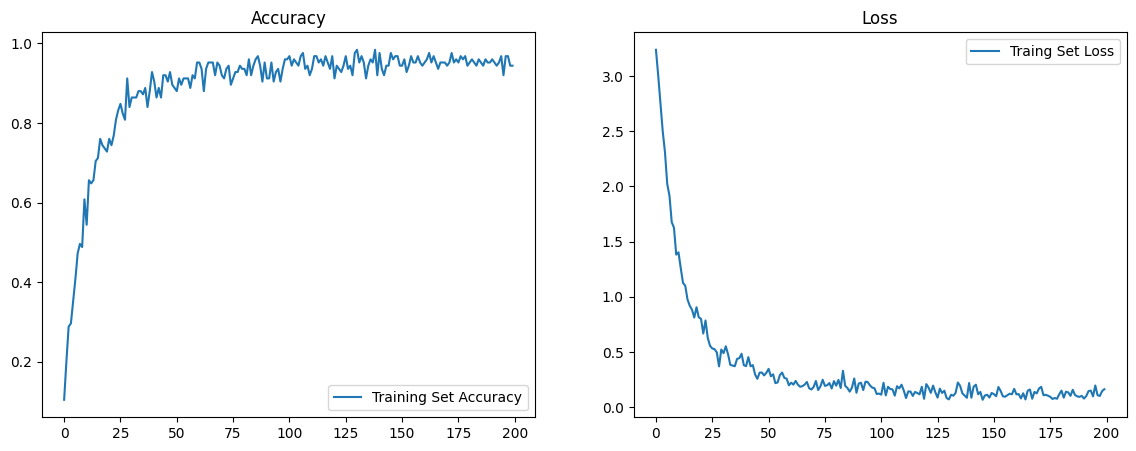

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='Training Set Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='Traing Set Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()